In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LOAD DATA

In [3]:
def load_data_from_folder(folder_path):
    features = pd.read_csv(f"{folder_path}/gin_gout_ratio.csv", header=None).values
    labels = pd.read_csv(f"{folder_path}/test_info.csv", header=None)
    V = labels.iloc[:, 0].values
    C = labels.iloc[:, 1].values
    A = V - C
    y = np.column_stack((A, C))  # Labels: [A, C]
    return features, y

In [4]:
X_d1, y_d1 = load_data_from_folder("Data_D1")
X_d2, y_d2 = load_data_from_folder("Data_D2")
X_extra, y_extra = load_data_from_folder("Data")

In [5]:
X_all = np.vstack([X_d1, X_d2, X_extra])
y_all = np.vstack([y_d1, y_d2, y_extra])
A_all = y_all[:, 0]

In [28]:
print("🧩 Unique values of A:", np.unique(y_all[:, 0]))
print("🧩 Unique values of C:", np.unique(y_all[:, 1]))

🧩 Unique values of A: [12.5 25.  37.5 50.  75. ]
🧩 Unique values of C: [12.5 25.  37.5 50.  75. ]


# MASKING FOR INTERPOLATION AND EXTRAPOLATION

In [46]:
mask_train = (A_all == 12.5) | (A_all == 37.5)
mask_interp = A_all == 25.0
mask_extra = (A_all == 50.0) | (A_all == 75.0)

In [47]:
X_train, y_train = X_all[mask_train], y_all[mask_train]
X_interp, y_interp = X_all[mask_interp], y_all[mask_interp]
X_extra, y_extra = X_all[mask_extra], y_all[mask_extra]

# SCALING DATA

In [48]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_interp_scaled = scaler.transform(y_interp)
y_extra_scaled = scaler.transform(y_extra)

# BUILD MODELS

In [49]:
def build_simple_nn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(40, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [50]:
def build_iterative_nn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim + 2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [51]:
def iterative_predict(model, X, iterations=5, A0=50, C0=100):
    A = np.full((X.shape[0], 1), A0)
    C = np.full((X.shape[0], 1), C0)
    for _ in range(iterations):
        preds = model.predict(np.hstack([X, A, C]), verbose=0)
        A, C = preds[:, 0:1], preds[:, 1:2]
    return np.hstack([A, C])

# TRAIN SIMPLE NN

In [52]:
simple_nn = build_simple_nn(X_train.shape[1])
simple_nn.fit(X_train, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# TRAIN ITERATIVE NN

In [53]:
iter_nn = build_iterative_nn(X_train.shape[1])
iter_nn.fit(np.hstack([X_train, np.zeros((X_train.shape[0], 2))]), y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# PREDICTIONS: INTERPOLATION

In [54]:
pred_interp_simple = scaler.inverse_transform(simple_nn.predict(X_interp))
pred_interp_iter = scaler.inverse_transform(iterative_predict(iter_nn, X_interp))
y_interp_actual = y_interp

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


# PREDICTIONS: EXTRAPOLATION

In [55]:
pred_extra_simple = scaler.inverse_transform(simple_nn.predict(X_extra))
pred_extra_iter = scaler.inverse_transform(iterative_predict(iter_nn, X_extra))
y_extra_actual = y_extra

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


# PRINTING METRICS

In [56]:
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"🔍 {name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}\n")

In [57]:
print("📈 Interpolation Results (A = 25 Mbps):")
print_metrics("Simple NN", y_interp_actual, pred_interp_simple)
print_metrics("Iterative NN", y_interp_actual, pred_interp_iter)

📈 Interpolation Results (A = 25 Mbps):
🔍 Simple NN:
  MSE: 501.6411
  MAE: 15.6009

🔍 Iterative NN:
  MSE: 519.1414
  MAE: 17.3196



In [58]:
print("📈 Extrapolation Results (A = 50, 75 Mbps):")
print_metrics("Simple NN", y_extra_actual, pred_extra_simple)
print_metrics("Iterative NN", y_extra_actual, pred_extra_iter)

📈 Extrapolation Results (A = 50, 75 Mbps):
🔍 Simple NN:
  MSE: 832.5233
  MAE: 25.3728

🔍 Iterative NN:
  MSE: 881.1335
  MAE: 26.8054



# PLOTTING GRAPHS

In [59]:
def plot_grouped_C_predictions(true_C, pred_C_dict, title):
    unique_C = np.sort(np.unique(true_C))
    plt.figure(figsize=(8, 5))

    styles = {
        "Simple NN": {"color": "tab:blue", "marker": "o"},
        "Iterative NN": {"color": "tab:orange", "marker": "s"}
    }

    for label, pred_C in pred_C_dict.items():
        means, stds = [], []
        for val in unique_C:
            mask = np.abs(true_C - val) < 0.1
            if np.any(mask):
                means.append(np.mean(pred_C[mask]))
                stds.append(np.std(pred_C[mask]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(unique_C, means, yerr=stds, fmt=styles[label]["marker"] + "-", 
                     capsize=5, label=label, color=styles[label]["color"], 
                     markersize=8, linewidth=2)

    # Ideal y=x line
    max_val = max(np.max(true_C), *[np.nanmax(p) for p in pred_C_dict.values()]) + 10
    plt.plot([0, max_val], [0, max_val], 'k--', label='Ideal (y = x)', linewidth=1.2)
    plt.xlabel("True Cross Traffic (C) [Mbps]")
    plt.ylabel("Predicted C [Mbps]")
    plt.title(title)
    plt.xticks(unique_C)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

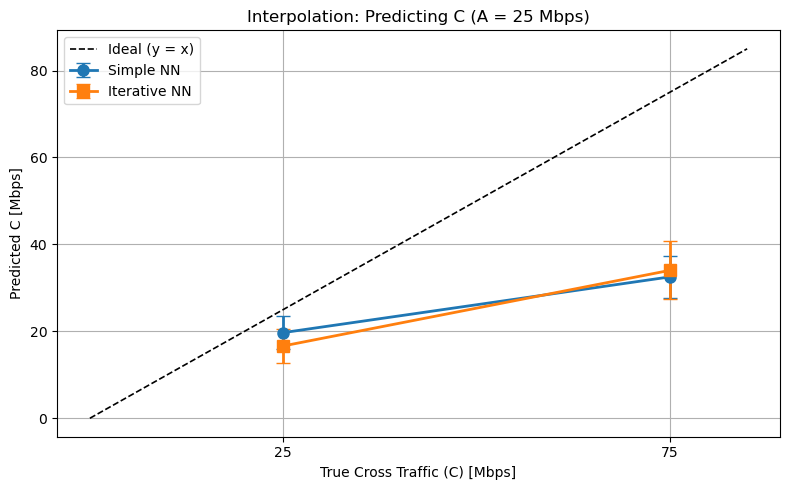

In [60]:
plot_grouped_C_predictions(
    true_C=y_interp_actual[:, 1],
    pred_C_dict={
        "Simple NN": pred_interp_simple[:, 1],
        "Iterative NN": pred_interp_iter[:, 1]
    },
    title="Interpolation: Predicting C (A = 25 Mbps)"
) 

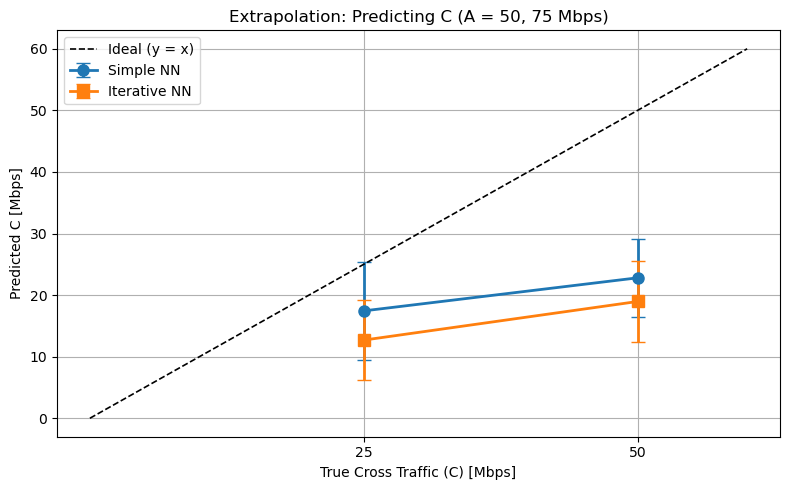

In [61]:
plot_grouped_C_predictions(
    true_C=y_extra_actual[:, 1],
    pred_C_dict={
        "Simple NN": pred_extra_simple[:, 1],
        "Iterative NN": pred_extra_iter[:, 1]
    },
    title="Extrapolation: Predicting C (A = 50, 75 Mbps)"
)